In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
import os
import pathlib
from PIL import Image 
from sklearn.model_selection import train_test_split
%matplotlib inline

from matplotlib import cm
import seaborn as sns

from tensorflow.keras.layers import Input, Dense 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D 
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras import Sequential
from tensorflow.keras import callbacks

from tensorflow.keras.applications.vgg16 import VGG16


from sklearn import metrics # Pour évaluer les modèles

import itertools # Pour créer des iterateurs

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Un seul modèle pour tout prédire  : catégorie, si maladie, type de maladie - 38 classes

## classifier tous les types de maladie (sans modèle intérmédiaire)

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/PlantSpy_Dataset_18K/PlantSpy_Dataset_18K.csv', index_col=0)

In [ ]:
data['cat_maladie_2'] = data['categorie'] + '_'+ data['cat_maladie'] 

In [ ]:
data.to_csv('/content/drive/MyDrive/PlantSpy_Dataset_18K/PlantSpy_Dataset_18K_v2.csv')

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/PlantSpy_Dataset_18K/PlantSpy_Dataset_18K_v2.csv')

In [ ]:
data.head()

,Unnamed: 0,imgPath,imgName,newImgName,categorie,cat_maladie,healthy,cat_maladie_2
0,0,/content/drive/MyDrive/Kaggle/new-plant-diseas...,ac61c972-546d-4977-ac4a-085f98bbf206___FREC_Sc...,Apple_scab_ac61c972-546d-4977-ac4a-085f98bbf20...,Apple,Apple_scab,0,Apple_Apple_scab
1,1,/content/drive/MyDrive/Kaggle/new-plant-diseas...,7e32ce27-bc89-4fca-9f49-c50de91210d1___FREC_C....,Cedar_apple_rust_7e32ce27-bc89-4fca-9f49-c50de...,Apple,Cedar_apple_rust,0,Apple_Cedar_apple_rust
2,2,/content/drive/MyDrive/Kaggle/new-plant-diseas...,8cf66a75-d71b-4808-a251-c929ecfa80bc___RS_HL 7...,Apple_8cf66a75-d71b-4808-a251-c929ecfa80bc___R...,Apple,healthy,1,Apple_healthy
3,3,/content/drive/MyDrive/Kaggle/new-plant-diseas...,b1efda88-84a3-4d96-b3bf-48d7e12155e9___FREC_Sc...,Apple_scab_b1efda88-84a3-4d96-b3bf-48d7e12155e...,Apple,Apple_scab,0,Apple_Apple_scab
4,4,/content/drive/MyDrive/Kaggle/new-plant-diseas...,a572ba2c-a691-4133-bb2f-e6e97edb749c___JR_FrgE...,Black_rot_a572ba2c-a691-4133-bb2f-e6e97edb749c...,Apple,Black_rot,0,Apple_Black_rot


In [ ]:
target = data['cat_maladie_2']

In [ ]:
img_path = pathlib.Path('/content/drive/MyDrive/PlantSpy_Dataset_18K/')

X_img=[]

for i in range(data.shape[0]):
  imgPath = str(img_path) + '/' + data['newImgName'].iloc[i]
  #print(imgPath)
  img =cv2.imread(str(imgPath), cv2.IMREAD_COLOR )
  #print(img.shape)
  img_resized = cv2.resize(img, (100,100)) 
  X_img.append(np.array(img_resized))

#34 min ... 
X_img = np.array(X_img)
X_img = X_img.astype('float32')

In [ ]:
data.shape

(18004, 8)

In [ ]:
target.value_counts() # 38 categorie

Raspberry_healthy                              1286
Orange_Haunglongbing_(Citrus_greening)         1286
Soybean_healthy                                1286
Blueberry_healthy                              1286
Squash_Powdery_mildew                          1286
Cherry_healthy                                  689
Peach_Bacterial_spot                            667
Strawberry_healthy                              662
Pepper_healthy                                  655
Pepper_Bacterial_spot                           631
Strawberry_Leaf_scorch                          624
Peach_healthy                                   619
Cherry_Powdery_mildew                           597
Potato_Late_blight                              463
Potato_Early_blight                             428
Potato_healthy                                  395
Grape_Black_rot                                 348
Grape_Esca_(Black_Measles)                      346
Apple_Apple_scab                                342
Corn_Common_

In [ ]:
list_38_categorie = [ 
'Raspberry_healthy'                              ,
'Orange_Haunglongbing_(Citrus_greening)'         ,
'Soybean_healthy'                                ,
'Blueberry_healthy'                              ,
'Squash_Powdery_mildew'                          ,
'Cherry_healthy'                                  ,
'Peach_Bacterial_spot'                            ,
'Strawberry_healthy'                              ,
'Pepper_healthy'                                  ,
'Pepper_Bacterial_spot'                           ,
'Strawberry_Leaf_scorch'                          ,
'Peach_healthy'                                   ,
'Cherry_Powdery_mildew'                           ,
'Potato_Late_blight'                              ,
'Potato_Early_blight'                             ,
'Potato_healthy'                                  ,
'Grape_Black_rot'                                 ,
'Grape_Esca_(Black_Measles)'                      ,
'Apple_Apple_scab'                                ,
'Corn_Common_rust_'                               ,
'Apple_healthy'                                   ,
'Corn_Northern_Leaf_Blight'                       ,
'Apple_Black_rot'                                 , 
'Grape_Leaf_blight_(Isariopsis_Leaf_Spot)'        ,
'Corn_healthy'                                    ,
'Corn_Cercospora_leaf_spot Gray_leaf_spot'        ,
'Apple_Cedar_apple_rust'                          ,
'Grape_healthy'                                   ,
'Tomato_Early_blight'                             ,
'Tomato_Bacterial_spot'                           ,
'Tomato_Spider_mites Two-spotted_spider_mite'     ,
'Tomato_Leaf_Mold'                                ,
'Tomato_healthy'                                  ,
'Tomato_Tomato_mosaic_virus'                      ,
'Tomato_Tomato_Yellow_Leaf_Curl_Virus'            ,
'Tomato_Target_Spot'                              ,
'Tomato_Septoria_leaf_spot'                       ,
'Tomato_Late_blight'                              
                ]

In [ ]:
list_38_categorie.sort()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_img, target, random_state = 1234, test_size=0.25)


In [ ]:
# Diviser les pixels des données X_train et X_test par 255 afin qu'ils soient compris entre 0 et 1
X_train = X_train / 255
X_test = X_test / 255

In [ ]:
from sklearn.preprocessing import LabelEncoder
encoderTM =  LabelEncoder()
y = encoderTM.fit_transform(target)


## Lenet + generateur images + Callbacks

In [ ]:
early_stopping = callbacks.EarlyStopping(monitor = 'val_loss',
                        patience = 8,
                        mode = 'min',
                        restore_best_weights = True)

lr_plateau = callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                            patience=4,
                            factor=0.5,
                            verbose=2,
                            mode='min')

In [ ]:
train_data_generator = ImageDataGenerator(
        rotation_range=50,
        width_shift_range=1,
        height_shift_range=1,
        zoom_range=[0.7, 1.2],
        horizontal_flip=True)

test_data_generator = ImageDataGenerator()

In [ ]:
batch_size = 100

training_data = train_data_generator.flow(X_train, y_train, batch_size=batch_size)
test_data = test_data_generator.flow(X_test, y_test, batch_size=batch_size)

In [ ]:
input_shape = (100,100,3)

model_LeNet1 = Sequential()
model_LeNet1.add(Conv2D(filters=30, kernel_size=(5, 5), padding='valid', input_shape=input_shape, activation='relu'))
model_LeNet1.add(MaxPooling2D(pool_size=(3, 3)))
model_LeNet1.add(Dropout(rate=0.2))
model_LeNet1.add(Conv2D(filters=64, kernel_size=(3, 3), padding='valid', activation='relu'))
model_LeNet1.add(MaxPooling2D(pool_size=(2, 2)))
model_LeNet1.add(Conv2D(filters=32, kernel_size=(3, 3), padding='valid', activation='relu'))
model_LeNet1.add(MaxPooling2D(pool_size=(2, 2)))
model_LeNet1.add(Dropout(rate=0.2))
model_LeNet1.add(Flatten())
model_LeNet1.add(Dense(units=64, activation='relu'))
model_LeNet1.add(Dense(units=38, activation='softmax'))

In [ ]:
model_LeNet1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
apply_LeNet1 = model_LeNet1.fit_generator(generator = training_data, 
                              epochs = 50, # passser de 15 à 50
                              steps_per_epoch = len(X_train)//batch_size,
                              validation_data = test_data,
                              validation_steps = len(X_test)//batch_size,
                              callbacks = [early_stopping,lr_plateau])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/50
135/135 [==============================] - 180s 1s/step - loss: 3.0399 - accuracy: 0.2036 - val_loss: 2.4454 - val_accuracy: 0.3396 - lr: 0.0010
Epoch 2/50
135/135 [==============================] - 174s 1s/step - loss: 2.1504 - accuracy: 0.4126 - val_loss: 1.7014 - val_accuracy: 0.5409 - lr: 0.0010
Epoch 3/50
135/135 [==============================] - 172s 1s/step - loss: 1.6815 - accuracy: 0.5295 - val_loss: 1.4504 - val_accuracy: 0.5987 - lr: 0.0010
Epoch 4/50
135/135 [==============================] - 172s 1s/step - loss: 1.4554 - accuracy: 0.5870 - val_loss: 1.4355 - val_accuracy: 0.5907 - lr: 0.0010
Epoch 5/50
135/135 [==============================] - 174s 1s/step - loss: 1.4138 - accuracy: 0.6034 - val_loss: 1.1020 - val_accuracy: 0.6840 - lr: 0.0010
Epoch 6/50
135/135 [==============================] - 174s 1s/step - loss: 1.2004 - accuracy: 0.6542 - val_loss: 1.1098 - val_accuracy: 0.6831 - lr: 0.0010
Epoch 7/50
135/135 [==============================] - 174s 1s/st

In [ ]:
model_LeNet1.save('/content/drive/MyDrive/model_Classif_TypeMaladie_18K_V2')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/model_Classif_TypeMaladie_18K_V2/assets


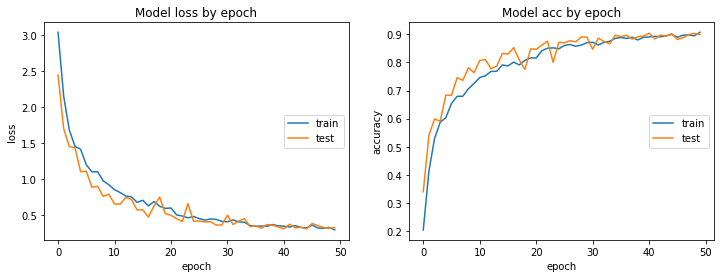

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(apply_LeNet1.history['loss'])
plt.plot(apply_LeNet1.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')

plt.subplot(122)
plt.plot(apply_LeNet1.history['accuracy'])
plt.plot(apply_LeNet1.history['val_accuracy'])
plt.title('Model acc by epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right');

In [ ]:
test_pred_LeNet1 = model_LeNet1.predict(X_test)

test_pred_LeNet1_class = test_pred_LeNet1.argmax(axis = 1)

In [ ]:
test_pred_LeNet1_label = encoder.inverse_transform(pd.DataFrame(test_pred_LeNet1_class, columns=['categorie']))
y_test_label = encoder.inverse_transform(pd.DataFrame(y_test, columns=['categorie'])) 

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
print(metrics.classification_report(y_test_label, test_pred_LeNet1_label))

                                             precision    recall  f1-score   support

                           Apple_Apple_scab       0.86      0.70      0.78        81
                            Apple_Black_rot       0.91      0.84      0.87        82
                     Apple_Cedar_apple_rust       0.97      0.84      0.90        70
                              Apple_healthy       0.81      0.76      0.78        76
                          Blueberry_healthy       0.96      0.95      0.95       316
                      Cherry_Powdery_mildew       0.97      0.94      0.95       172
                             Cherry_healthy       0.99      0.95      0.97       160
   Corn_Cercospora_leaf_spot Gray_leaf_spot       0.89      0.82      0.85        76
                          Corn_Common_rust_       0.95      0.99      0.97        77
                  Corn_Northern_Leaf_Blight       0.95      0.91      0.93        76
                               Corn_healthy       0.99      0.93

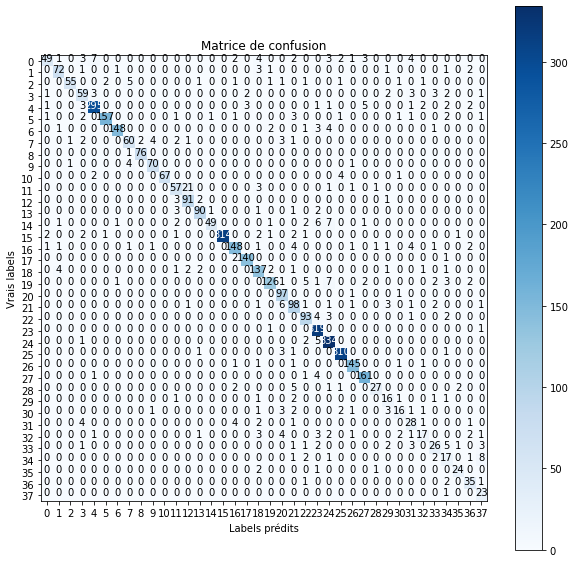

In [ ]:
# Matrice de Confusion

cnf_matrix = metrics.confusion_matrix(y_test_label, test_pred_LeNet1_label)

classes = range(0,38)
plt.figure(figsize=(10, 10))


plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')
plt.title("Matrice de confusion")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, cnf_matrix[i, j],
             horizontalalignment="center",
             color="white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

plt.ylabel('Vrais labels')

plt.xlabel('Labels prédits')

plt.show()

# 2- Appliquer le modèle au dataset "Valid"

In [ ]:
folder_path = "/content/drive/MyDrive/NewPlantDiseasesDataset/valid/"

X_valid0=[]
y_valid0=[] # La categorie_maladie


width = 100
height = 100 # resize to 100x100 to solve the RAM issue in Kaggle notebooks

for path, dirs, files in os.walk(folder_path):
    for repertoire in dirs:
      chemin=folder_path+repertoire
      for images in os.listdir(chemin):
        img=cv2.imread(chemin+'/'+images,cv2.IMREAD_COLOR )
        img_resized = cv2.resize(img, (width,height)) 
        X_valid0.append(np.array(img_resized))
        
        categorie =repertoire.split('___')[0]
        maladie = repertoire.split('___')[1]
        categorie_maladie = categorie+'_'+maladie
        y_valid0.append(categorie_maladie) 

In [ ]:
X_valid= np.array(X_valid0)/255
X_valid = X_valid.astype('float32')
y_valid= np.array(y_valid0)

In [ ]:
from sklearn.preprocessing import LabelEncoder
encoder =  LabelEncoder()
y_valid = encoder.fit_transform(y_valid)


In [ ]:
model_loaded_V2 = tf.keras.models.load_model('/content/drive/MyDrive/model_Classif_TypeMaladie_18K_V2')


In [ ]:
test_pred_LeNet1_valid = model_loaded_V2.predict(X_valid)

test_pred_LeNet1_valid_class = test_pred_LeNet1_valid.argmax(axis = 1)

In [ ]:
test_pred_LeNet1_validlabel = encoder.inverse_transform(pd.DataFrame(test_pred_LeNet1_valid_class, columns=['categorie_maladie'])) 
y_valid_label = encoder.inverse_transform(pd.DataFrame(y_valid, columns=['categorie_maladie'])) 


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
print(metrics.classification_report(y_valid_label, test_pred_LeNet1_validlabel))

                                                  precision    recall  f1-score   support

                                Apple_Apple_scab       0.90      0.66      0.76       504
                                 Apple_Black_rot       0.91      0.82      0.86       497
                          Apple_Cedar_apple_rust       0.92      0.83      0.87       440
                                   Apple_healthy       0.87      0.76      0.81       502
                               Blueberry_healthy       0.84      0.95      0.89       454
          Cherry_(including_sour)_Powdery_mildew       0.90      0.91      0.91       421
                 Cherry_(including_sour)_healthy       0.95      0.92      0.93       456
Corn_(maize)_Cercospora_leaf_spot Gray_leaf_spot       0.78      0.78      0.78       410
                       Corn_(maize)_Common_rust_       0.97      0.99      0.98       477
               Corn_(maize)_Northern_Leaf_Blight       0.89      0.84      0.87       477
         